# 00 - PDB structure analysis


We queried PDB to find out how many Nitrogenase structures have been deposited. Here, we plot the results from that search.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import requests
plt.rcParams['svg.fonttype'] = 'none'

Reading the file requires handling some format/data issues, as the information is provided as a very complex json file.

In [2]:
u = []
for entry in json.load(open('../data/report_N2ases_PDB.json')):
    general = dict(
        pdb_id = entry['identifier'],
        resolution = entry['data']['rcsb_entry_info']['resolution_combined'][0],
        year = entry['data']['rcsb_primary_citation']['year'],
    )
    
    for entity in entry['data']['polymer_entities']:
        try:
            entity_ = dict(
                sequence=entity['entity_poly']['pdbx_seq_one_letter_code_can'],
                nchains=entity['rcsb_polymer_entity']['pdbx_number_of_molecules'],
                organism=entity['rcsb_entity_source_organism'][0]['ncbi_scientific_name'],
                gene_name=entity['rcsb_entity_source_organism'][0]['rcsb_gene_name'][0]['value'],
                ** general
            )
            u += [entity_]
        except TypeError:
            entity_ = dict(
                sequence=entity['entity_poly']['pdbx_seq_one_letter_code_can'],
                nchains=entity['rcsb_polymer_entity']['pdbx_number_of_molecules'],
                organism=entity['rcsb_entity_source_organism'][0]['ncbi_scientific_name'],
                ** general
            )
            u += [entity_]

u = pd.DataFrame.from_records(u).query('pdb_id != "8ENO"').dropna(subset=['gene_name'])
u['organism'] = u['organism'].apply(lambda x: x.replace(' DJ', ''))

Ploting the number of structures by year.

<Axes: xlabel='year', ylabel='Count'>

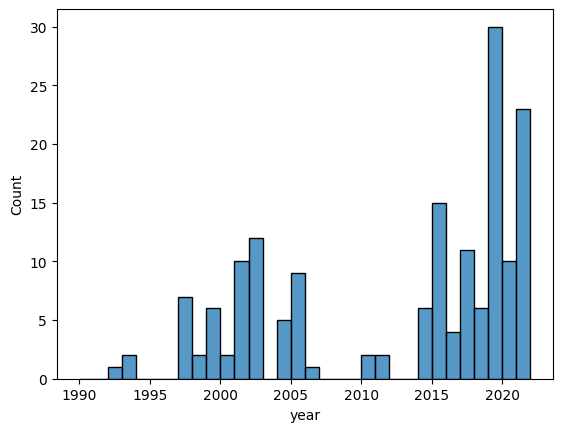

In [3]:
sns.histplot(x='year', data=u, bins=np.arange(1990, 2023, 1))

There might be an "increasing" trend. 

<Axes: xlabel='resolution', ylabel='Count'>

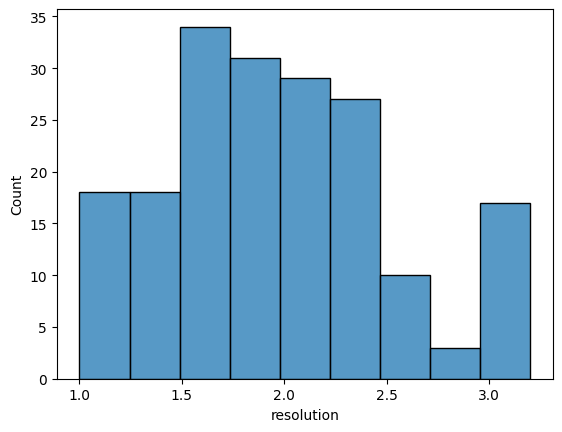

In [4]:
sns.histplot(x='resolution', data=u)

Now, we plot by organism.

<Axes: xlabel='count', ylabel='organism'>

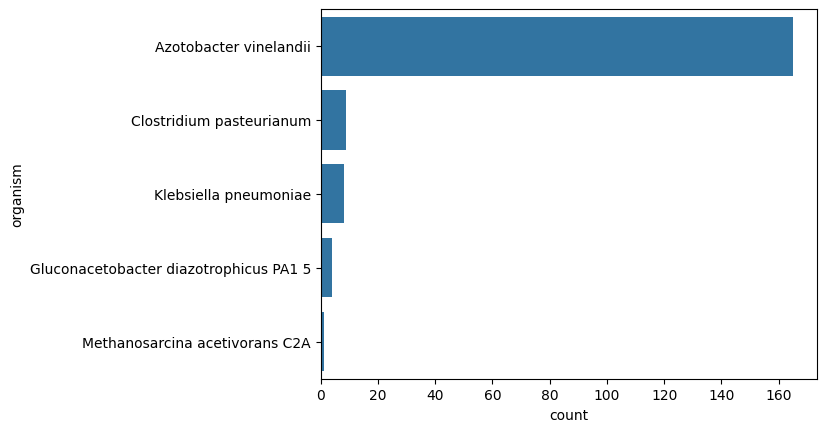

In [5]:
sns.countplot(y='organism', data=u)

Only fixe organisms!

In [6]:
u[['gene_name', 'nchains', 'organism', 'pdb_id']]

,gene_name,nchains,organism,pdb_id
0,vnfD,2,Azotobacter vinelandii,5N6Y
1,vnfK,2,Azotobacter vinelandii,5N6Y
2,vnfG,2,Azotobacter vinelandii,5N6Y
3,vnfD,2,Azotobacter vinelandii,7ADY
4,vnfK,2,Azotobacter vinelandii,7ADY
...,...,...,...,...
213,nifH,2,Methanosarcina acetivorans C2A,6NZJ
214,nifH1,2,Azotobacter vinelandii,1NIP
215,nifH1,2,Azotobacter vinelandii,1XD9
216,nifH1,2,Clostridium pasteurianum,1CP2


Now, we will classify the instances depending on the stoichiometry of the model, the genes (Nif, Anf, etc) and we wil sort it by year.

In [7]:
def type_gene_name(x):
    return x[:3]

def subunit_name(x):
    x = x[3:]
    if x == 'H1':
        return 'H'
    return x

def classify(x):

    chains = ['D'] * int(x.D) + ['K'] * int(x.K) + ['H'] * int(x.H) + ['G'] * int(x.G)
    chains = ''.join(chains)
    out = []
    for char in np.unique(list(chains)):
        out.append(f'{char}{chains.count(char)}')

    return ''.join(out)

u['type'] = u['gene_name'].apply(lambda x: type_gene_name(x))
u['subunit'] = u['gene_name'].apply(lambda x: subunit_name(x))
v = u.pivot(index=['pdb_id', 'organism', 'resolution', 'year', 'type'], columns='subunit', values='nchains').fillna(0).reset_index()
v['structure_class'] = v.apply(classify, axis=1)

In [8]:

selection = v.sort_values(by=['resolution']).reset_index(drop=True).set_index('pdb_id').reset_index(level=[0])
# selection['pdb_file'] = selection['pdb_id'].apply(download_structure)
# selection.apply(lambda x: open(f'../structures/benchmark/component1/{x.pdb_id}.pdb', 'w').write(x.pdb_file), axis=1)
selection

subunit,pdb_id,organism,resolution,year,type,D,G,H,K,structure_class
0,3U7Q,Azotobacter vinelandii,1.00,2011.0,nif,2.0,0.0,0.0,2.0,D2K2
1,7ADR,Azotobacter vinelandii,1.00,2020.0,vnf,2.0,2.0,0.0,2.0,D2G2K2
2,7AIZ,Azotobacter vinelandii,1.05,2021.0,vnf,2.0,2.0,0.0,2.0,D2G2K2
3,7ADY,Azotobacter vinelandii,1.05,2020.0,vnf,2.0,2.0,0.0,2.0,D2G2K2
4,6N4L,Azotobacter vinelandii,1.13,2019.0,nif,0.0,0.0,1.0,0.0,H1
...,...,...,...,...,...,...,...,...,...,...
99,1MIO,Clostridium pasteurianum,3.00,1993.0,nif,2.0,0.0,0.0,2.0,D2K2
100,8BTS,Azotobacter vinelandii,3.03,2023.0,nif,4.0,0.0,0.0,4.0,D4K4
101,2AFI,Azotobacter vinelandii,3.10,2005.0,nif,4.0,0.0,8.0,4.0,D4H8K4
102,1M1Y,Azotobacter vinelandii,3.20,2002.0,nif,4.0,0.0,8.0,4.0,D4H8K4


This can be useful for future queries

In [9]:
selection = v.sort_values(by=['resolution']).reset_index().drop(columns=['index'])# .rename_index('index')
selection.index.rename('index', inplace=True)
selection['D'] = selection['D'].astype(int)
selection['K'] = selection['K'].astype(int)
selection['G'] = selection['G'].astype(int)
selection['H'] = selection['H'].astype(int)

Finally, we save the resulting file.

In [15]:
selection.to_csv('../data/pdb-processed-clean-table.csv', index=None, sep='\t')